## Blackjack Example
### States (200 of them):
- Current sum (12-21)
- Dealer’s showing card (ace-10)
- Do I have a \useable" ace? (yes-no)

### action
- Action stick: Stop receiving cards (and terminate)
- Action twist: Take another card (no replacement)

### Reward for stick:
- +1 if sum of cards > sum of dealer cards
- 0 if sum of cards = sum of dealer cards
- -1 if sum of cards < sum of dealer cards

### Reward for twist:
- -1 if sum of cards > 21 (and terminate)
- 0 otherwise

### Transitions: automatically twist if sum of cards < 12

In [1]:
import numpy as np
import random
STICK = 1
TWIST = 0

class Poker():
    def __init__(self):
        self.cards_ = []
        for i in range(1,11):
            self.cards_.extend([i]*4)
        for i in range(11,14):
            self.cards_.extend([10]*4)
        random.shuffle(self.cards_)
    def hit(self):
        return self.cards_.pop()

class Player():
    def __init__(self):
        self.usable_ace_ = False
        self.usable_ace2_ = False
        self.cards_ = []
        
    def hit(self, card):
        self.cards_.append(card)
        if card == 1:
            if self.usable_ace_:
                self.usable_ace2_ = True
            if sum(self.cards_)+9 <= 21:
                self.usable_ace_ = True
            
    def score(self):
        s = sum(self.cards_)
        if self.usable_ace2_ and s+18 <= 21:
            return sum(self.cards_)+18
        if self.usable_ace_ and s+9 <= 21:
            return s+9
        if s <= 21:
            return s
        return -1

class Dealer(Player):
    def __init__(self, show_card):
        Player.__init__(self)
        self.hit(show_card)
        self.show_card_ = show_card
    def final_score(self, poker):
        while 0 < self.score() < 17:
            self.hit(poker.hit())
        return self.score() 
    
class Blackjack(object):
    def __init__(self):
        self.poker_ = Poker()
        self.dealer_ = Dealer(self.poker_.hit())
        self.player_ = Player()
        self.player_.hit(self.poker_.hit())
        self.cmp_ = lambda x,y: 1 if x>y else (-1 if x<y else 0)
        
    def reset(self):
        self.__init__()
        
    def state(self):
        return int(self.player_.usable_ace_), self.dealer_.show_card_, self.player_.score()
    
    def step(self, action):
        if action == STICK:
            ret = self.cmp_(self.player_.score(), self.dealer_.final_score(self.poker_))
            return self.state(), ret, 1, self.player_.cards_
        else:
            self.player_.hit(self.poker_.hit())      
            if 0 < self.player_.score() < 21:
                return self.state(), 0, 0, self.player_.cards_
            else:
                ret = self.cmp_(self.player_.score(), self.dealer_.final_score(self.poker_))
                return self.state(), ret, 1, self.player_.cards_
            
class Trainer():
    def __init__(self):
        self.q_ = np.zeros((2,11,21,2), dtype=np.float64)
        self.n_ = np.zeros((2,11,21,2), dtype=np.uint32)
        
    def pi(self, s, eps=0.1):
        if s[2]<12:
            return 0
        if random.random()>eps:
            ua, sh, sc = s
            return np.argmax(self.q_[s])
        else:
            return random.randint(0,1)
    
    def train(self, n_episode = 1):
        eps = 1
        for _ in range(n_episode):
            env = Blackjack()
            s = env.state()
            states = [s]
            actions = []
            while 1:
                a = self.pi(s, eps)
                states.append(s)
                actions.append(a)
                s, r, t, info = env.step(a)
                if t: break
            for a,(ua, sh, sc) in zip(actions,states):
                n = self.n_[ua, sh, sc, a]
                self.q_[ua, sh, sc, a] = self.q_[ua, sh, sc, a]*n/(n+1) + r/(n+1)
                self.n_[ua, sh, sc, a] += 1
#             eps -= 1./n_episode

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def plot_v(v, name):
    x = np.arange(1, 11)
    y = np.arange(12, 21)
    x, y = np.meshgrid(x, y)
    z = v[x, y]
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='rainbow')
    plt.title(name)
    plt.show()

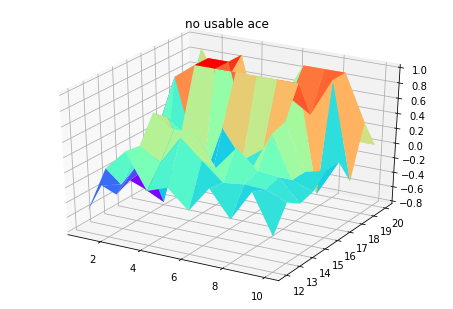

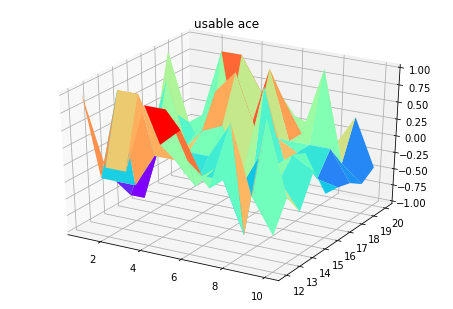

In [3]:
t=Trainer()
t.train(10000)
plot_v(t.q_.max(axis=3)[0], 'no usable ace')
plot_v(t.q_.max(axis=3)[1], 'usable ace')

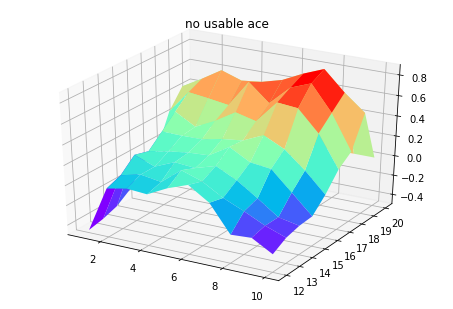

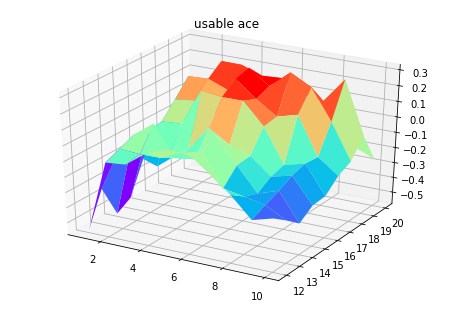

In [4]:
t=Trainer()
t.train(500000)
plot_v(t.q_.max(axis=3)[0], 'no usable ace')
plot_v(t.q_.max(axis=3)[1], 'usable ace')

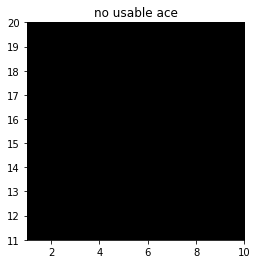

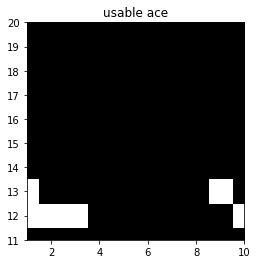

In [5]:
def plot_pi(pi, name):
    plt.imshow(pi.transpose(), cmap='gray')
    plt.xlim(1,10)
    plt.ylim(11,20)
    plt.title(name)
    plt.show()
pi=(t.q_[:,:,:,0]>t.q_[:,:,:,1]).astype(np.uint8)
plot_pi(pi[0],'no usable ace')
plot_pi(pi[1],'usable ace')